# Historical Storm Data: NOAA

> This page contains code to explore the NOAA datasets that have the records of every recorded storm in the US over the last 50 years. We wanted to see if we could estimate the amount of damage that a disaster might cause, given the past recordings. We also wanted to see if we could estimate a possible range of destruction. 

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [14]:
details_2018 = pd.read_csv("./4_historical_storm_data/StormEvents_details-ftp_v1.0_d2018_c20190716 (1).csv")
locations_2018 = pd.read_csv("./4_historical_storm_data/StormEvents_locations-ftp_v1.0_d2018_c20190716 2.csv")

In [20]:
details_2018.columns = [x.lower() for x in list(details_2018.columns)]

In [21]:
locations_2018.columns = [x.lower() for x in list(locations_2018.columns)]

In [22]:
drop_columns = []

for i in details_2018.isna().sum().index:
    if (details_2018.isna().sum() > 40_000)[i]:
        drop_columns.append(i)

In [23]:
details_2018 = details_2018.drop(drop_columns, axis = 1)

In [25]:
merged = pd.merge(locations_2018, details_2018, on = "event_id")
merged.shape

(48472, 51)

In [27]:
merged.columns

Index(['yearmonth', 'episode_id_x', 'event_id', 'location_index', 'range',
       'azimuth', 'location', 'latitude', 'longitude', 'lat2', 'lon2',
       'begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
       'end_day', 'end_time', 'episode_id_y', 'state', 'state_fips', 'year',
       'month_name', 'event_type', 'cz_type', 'cz_fips', 'cz_name', 'wfo',
       'begin_date_time', 'cz_timezone', 'end_date_time', 'injuries_direct',
       'injuries_indirect', 'deaths_direct', 'deaths_indirect',
       'damage_property', 'damage_crops', 'source', 'magnitude', 'begin_range',
       'begin_azimuth', 'begin_location', 'end_range', 'end_azimuth',
       'end_location', 'begin_lat', 'begin_lon', 'end_lat', 'end_lon',
       'episode_narrative', 'event_narrative', 'data_source'],
      dtype='object')

In [30]:
merged[["begin_lat","end_lat", "event_type"]].head()

,begin_lat,end_lat,event_type
0,30.3100,30.3158,Flood
1,30.3100,30.3158,Flood
2,30.3100,30.3158,Flood
3,30.3100,30.3158,Flood
4,41.7551,41.7437,Flash Flood


In [74]:
X = merged[["range", "begin_lat", "end_lat", "event_type", "begin_lon", "end_lon", "location_index"]]

X = pd.get_dummies(X, columns = ["event_type"], drop_first= True)

X_train = X.drop(["end_lat","end_lon"], axis = 1)
y = X["end_lat"]

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y, random_state = 42)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

/Users/mdevlin/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/mdevlin/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/mdevlin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


In [79]:
en = ElasticNetCV()
en.fit(X_train, y_train)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

/Users/mdevlin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mdevlin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [80]:
en.score(X_train, y_train)

0.9998654564152379

In [81]:
en.score(X_test, y_test)

0.9998567029945428

In [107]:
pred = en.predict(X_test)
type(pred)

numpy.ndarray

In [98]:
en_df = pd.DataFrame(pred, columns = ["en_pred"])
en_df.head()

,en_pred
0,29.303339
1,34.824028
2,43.218854
3,36.012851
4,41.981260


In [108]:
true_df = pd.DataFrame(y_test.values, columns = ["true"])

In [110]:
true_df.head()

,true
0,29.2600
1,34.8026
2,43.2804
3,36.0010
4,42.0092


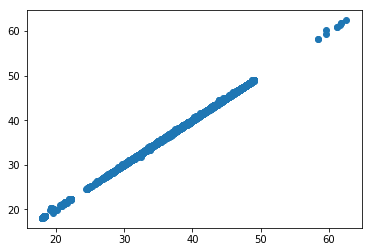

In [83]:
import matplotlib.pyplot as plt

plt.scatter(y_test, pred)

In [84]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [85]:
rf.score(X_train, y_train)

0.9999950901052638

In [86]:
rf.score(X_test, y_test)

0.9999792184973803

In [88]:
rf_pred = rf.predict(X_train)

In [99]:
rf_df = pd.DataFrame(rf_pred, columns = ["rf_pred"])
rf_df.head()

,rf_pred
0,37.613848
1,35.156890
2,48.777010
3,36.368045
4,40.818300


In [118]:
df = pd.concat([true_df, rf_df], axis = 1)
preds_df = pd.concat([df, en_df], axis =1)
preds_df.head()

,true,rf_pred,en_pred
0,29.2600,37.613848,29.303339
1,34.8026,35.156890,34.824028
2,43.2804,48.777010,43.218854
3,36.0010,36.368045,36.012851
4,42.0092,40.818300,41.981260


In [119]:
X = merged[["range", "begin_lat", "end_lat", "event_type", "begin_lon", "end_lon", "location_index"]]

X = pd.get_dummies(X, columns = ["event_type"], drop_first= True)

X_train = X.drop(["end_lat","end_lon"], axis = 1)
y = X["end_lon"]

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y, random_state = 42)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

/Users/mdevlin/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/mdevlin/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/mdevlin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


In [121]:
en = ElasticNetCV()
en.fit(X_train, y_train)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

/Users/mdevlin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/mdevlin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [122]:
en.fit(X_train, y_train)

/Users/mdevlin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001,
       fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
       n_jobs=None, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [123]:
en.score(X_train, y_train)

0.9997808981269285

In [124]:
en.score(X_test, y_test)

0.9997780682621998

In [137]:
pred = en.predict(X_train)
d= pd.DataFrame(pred, columns = ["en_pred"])

In [138]:
f = pd.DataFrame(y_test.values, columns = ["True"])

In [139]:
pd.concat([f, d], axis =1)

,True,en_pred
0,-89.9600,-79.675946
1,-83.7165,-90.124196
2,-92.9240,-105.625997
3,-95.8713,-105.477962
4,-76.7337,-72.861553
5,-80.8100,-76.607041
6,-88.8200,-90.736483
7,-92.0123,-97.112035
8,-91.6500,-90.555949
9,-85.5052,-101.669363


In [2]:
fig = plt.figure(figsize=(4,4))

merged["end_lat"].hist(alpha =0.9)
merged["begin_lat"].hist(alpha = 0.6)

> The above code was an attempt to predict the "end_lat" and "end_lon" of the storm based on a few other factors. We ended up with very high r2 scores, and we think this was because the beginning of a storm was not far enough away from the end(at least using lat and long) and so it was just predicting the same as the start of the storm.

In [7]:
def convert_letters(string):
    try:
        if string.find("K") > 0:
            return float(string.replace("K",""))*1_000
        elif string.find("M") > 0:
            return float(string.replace("M",""))*1_000_000
        elif string.find("B") > 0:
            return float(string.replace("B",""))*1_000_000_000
        else:
            return np.nan
    except:
        print (string)

In [8]:
def find_storm(lat, 
               long, 
               dist, 
               merged_dataframe,
               metric = "median"):
    
    merged_df = merged_dataframe.copy()
    
    merged_df_lat_mask_upper = merged_df["latitude"] <= (lat + dist)
    merged_df_lat_mask_lower = merged_df["latitude"] >= (lat - dist)
    merged_df_long_mask_upper = merged_df["longitude"] <= (long + dist)
    merged_df_long_mask_lower = merged_df["longitude"] >= (long - dist)
    
    merged_df["damage_property"] = merged_df["damage_property"].apply(lambda x: convert_letters(x) if type(x) != float else np.nan)
    
    data = merged_df[merged_df_lat_mask_lower & merged_df_lat_mask_upper & merged_df_long_mask_lower & merged_df_long_mask_upper]
    median = data.groupby("event_type").median()[["range","deaths_direct", "damage_property"]]
    median["count"] = data.groupby("event_type").count()["state"].values
    mean = data.groupby("event_type").mean()[["range", "deaths_direct", "damage_property"]]
    mean["count"] = data.groupby("event_type").count()["state"].values
    
    if metric == "mean":
        return mean.sort_values("count", ascending = False)
    else:
        return median.sort_values("count", ascending = False)
    
    
    

In [9]:
df = find_storm(41, -83, 5,merged, metric = "mean")

In [10]:
df

,range,deaths_direct,damage_property,count
event_type,,,,
Thunderstorm Wind,4.145594,0.001402,1.641422e+04,2854
Hail,3.721127,0.000000,7.099448e+03,1075
Marine Thunderstorm Wind,4.807018,0.000000,8.269231e+03,773
Flood,NaN,0.008772,3.281597e+05,342
Flash Flood,4.740000,0.007463,2.316842e+05,268
Tornado,2.948454,0.410256,2.997484e+06,117
Marine Hail,7.235294,0.000000,NaN,34
Waterspout,2.400000,0.000000,NaN,11
Lightning,1.500000,0.100000,1.000000e+04,10


> The above code takes the historical storm data and classifies it by lat,long and then returns stats for the event_types in that area based on range, damage_property costs and the number of storms. We eventually did not include this in the final tool because it did not seem necessary for an immediate response, but it could be something to be expanded on for recovery efforts.